In [56]:
%matplotlib inline
import cv2
import numpy as np
import pysrt
import time
import pickle
from matplotlib import pyplot as plt

In [32]:
# help functions
def get_time_from_fid(fid, fps):
    second = int(fid / fps)
    minute = int(second / 60)
    hour = int(minute / 60)
    return (hour, minute % 60, second % 60)

def get_time_from_second(second):
    minute = int(second / 60)
    hour = int(minute / 60)
    return (hour, minute % 60, second % 60)

def get_second(time):
    return time[0]*3600 + time[1]*60 + time[2]

In [90]:
# all check functions
def check_black_in_gt(black_frame_list, groundtruth, fps):
    gt_pair = []
    for gt in groundtruth:
        gt_pair.append((get_second(gt[0]), get_second(gt[1])))
    for fid in black_frame_list:
#         print(fid)
        second = int(fid / fps)
        drop_in = False
        for gt in gt_pair:
            if second >= gt[0]-2 and second <= gt[1]+2:
                drop_in = True
#                 print(gt)
                break;
        if not drop_in:
            print(fid, get_time_from_fid(fid, fps))

# visualize commercial result
def visualize_commercial(commercial_list, groundtruth):
    y_com = [1, 1]
    y_gt = [2, 2] 
    plt.figure(111)
    for com in commercial_list:
        text = 'our: ' + str(com[0][1]) + '-'+ str(com[1][1])
        plt.plot([get_second(com[0][1]), get_second(com[1][1])], y_com, 'r', linewidth=7.0, label=text)
    for gt in groundtruth:
        text = 'gt:  ' + str(gt[0]) + '-' + str(gt[1])
        plt.plot([get_second(gt[0]), get_second(gt[1])], y_gt, 'g', linewidth=7.0, label=text)

    legend = plt.legend(loc='best', shadow=True)
    plt.ylim([0, 10])
    plt.xlabel('video time (s)')
    cur_axes = plt.gca()
    cur_axes.axes.get_yaxis().set_visible(False)
    plt.show()    

In [25]:
# load commercial groundtruth
commercial_gt = {}
for line in open('../data/commercial_gt.csv'):
    columns = line[:-1].split(',')
    commercial_gt[columns[0]] = {'delay': float(columns[1]), 'span': []}
    for i in range(2, len(columns)):
        if columns[i] == '':
            continue
        span = columns[i].split('-')
        start = span[0].split(':')
        end = span[1].split(':')
        commercial_gt[columns[0]]['span'].append(((int(start[0]), int(start[1]), int(start[2])), (int(end[0]), int(end[1]), int(end[2]))))
#print(commercial_gt)

In [3]:
# scan all the videos and store black_frame_dict in pickle
black_frame_dict = {}
for line in open('../data/labeled_video_list.txt'):
    video_name = line[:-1]
    print(video_name)
    video_path = '../data/videos/' + video_name + '.mp4'
    srt_path = '../data/videos/' + video_name + '.cc5.srt'

    # load transcript
#     transcript = []
#     subs = pysrt.open(srt_path)
#     for sub in subs:
#         transcript.append((sub.text, tuple(sub.start)[:3], tuple(sub.end)[:3]))

    # load video
    cap = cv2.VideoCapture(video_path)
    video_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_w  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    video_length = int(video_frames / fps)

    fid = 0
    ret, frame = cap.read()
    pixel_sum = frame_w * frame_h
    BLACK_THRESH = 0.99 * pixel_sum
    black_frame_list = []

    start_time = time.time()
    while(ret):
        ret, frame = cap.read()
        if frame is None:
            break
        hist = cv2.calcHist([frame], [0, 1, 2], None, [16, 16, 16], [0, 256, 0, 256, 0, 256])
        if hist[0,0,0] > BLACK_THRESH:
            black_frame_list.append(fid)
        fid += 1
        if fid % 10000 == 0:
            print(fid)

    print("--- %s seconds ---" % (time.time() - start_time))        
    cap.release()
    black_frame_dict[video_name] = black_frame_list
    pickle.dump(black_frame_dict, open("../data/black_frame_dict.p", "wb" ))

MSNBC_20090703_010000_The_Rachel_Maddow_Show
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
--- 185.07295513153076 seconds ---
MSNBC_20110830_080000_The_Rachel_Maddow_Show
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
--- 189.19789290428162 seconds ---
MSNBCW_20120201_160000_MSNBC_Live
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
--- 187.5382113456726 seconds ---
MSNBCW_20160915_033000_Hardball_With_Chris_Matthews
10000
20000
30000
40000
50000
--- 70.53333735466003 seconds ---
FOXNEWS_20120201_160000_Happening_Now
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
--- 358.653995513916 seconds ---
FOXNEWS_20120201_180000_America_Live
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
--- 358.10101079940796 seconds ---
FOXNEWSW_20120201_210000_Your_World_With_Neil_Cavuto
1

In [86]:
# load black_frame_dict from pickle
black_frame_dict = pickle.load(open("../data/black_frame_dict.p", 'rb'))
video_name = 'MSNBCW_20160915_033000_Hardball_With_Chris_Matthews'
video_path = '../data/videos/' + video_name + '.mp4'
srt_path = '../data/videos/' + video_name + '.cc5.srt'
black_frame_list = black_frame_dict[video_name]

# load transcript
transcript = []
subs = pysrt.open(srt_path)
for sub in subs:
    transcript.append((sub.text, tuple(sub.start)[:3], tuple(sub.end)[:3]))

# load video
cap = cv2.VideoCapture(video_path)
video_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_w  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
video_length = int(video_frames / fps)
cap.release()

# check black_frame_list in groundtruth
groundtruth = commercial_gt[video_name]['span']
check_black_in_gt(black_frame_list, groundtruth, fps)

54343 (0, 30, 13)
54344 (0, 30, 13)
54345 (0, 30, 13)
54346 (0, 30, 13)
54347 (0, 30, 13)
54348 (0, 30, 13)
54349 (0, 30, 13)
54350 (0, 30, 13)
54351 (0, 30, 13)
54352 (0, 30, 13)
54353 (0, 30, 13)
54354 (0, 30, 13)
54355 (0, 30, 13)
54356 (0, 30, 13)
54357 (0, 30, 13)
54358 (0, 30, 13)
54359 (0, 30, 13)
54360 (0, 30, 13)
54361 (0, 30, 13)
54362 (0, 30, 13)
54363 (0, 30, 13)
54364 (0, 30, 13)
54365 (0, 30, 13)
54366 (0, 30, 14)
54367 (0, 30, 14)
54368 (0, 30, 14)
54369 (0, 30, 14)
54370 (0, 30, 14)
54371 (0, 30, 14)
54372 (0, 30, 14)
54373 (0, 30, 14)


In [87]:
# filter black window by checking continuous black frames numbers
CONTINUOUS_THRESH = 1
black_window_list = []
fid = -99
nframe = 1
for f in black_frame_list:
    if f == fid + nframe:
        nframe += 1
    else:
        if nframe >= CONTINUOUS_THRESH and fid != -99:
            black_time = get_time_from_fid((fid*2+nframe-1)/2, fps)
            black_window = (fid, fid+nframe-1, black_time)
            black_window_list.append(black_window)
            print(fid, fid+nframe-1, nframe)
            print(black_time)
        fid = f
        nframe = 1
if nframe >= CONTINUOUS_THRESH:
    black_time = get_time_from_fid((fid*2+nframe-1)/2, fps)
    black_window = (fid, fid+nframe-1, black_time)
    black_window_list.append(black_window)
    print(fid, fid+nframe, nframe)
    print(black_time)

5065 5080 16
(0, 2, 49)
6034 6036 3
(0, 3, 21)
8141 8142 2
(0, 4, 31)
8154 8161 8
(0, 4, 32)
8223 8223 1
(0, 4, 34)
10018 10023 6
(0, 5, 34)
10916 10917 2
(0, 6, 4)
11368 11392 25
(0, 6, 19)
20943 20963 21
(0, 11, 39)
22309 22312 4
(0, 12, 24)
22941 22998 58
(0, 12, 46)
25007 25007 1
(0, 13, 54)
25906 25906 1
(0, 14, 24)
26357 26382 26
(0, 14, 39)
38623 38641 19
(0, 21, 29)
39595 39595 1
(0, 22, 1)
39986 39986 1
(0, 22, 14)
41334 41335 2
(0, 22, 59)
42230 42231 2
(0, 23, 29)
43130 43131 2
(0, 23, 59)
47068 47078 11
(0, 26, 10)
49773 49773 1
(0, 27, 40)
53372 53400 29
(0, 29, 41)
54343 54374 31
(0, 30, 13)


In [60]:
# filter black window by checking the beginning and end of the video (abandoned)
BEGINNING_SECOND_THRESH = 60
for w in black_window_list:
    second = w[0] / fps
    if second < BEGINNING_SECOND_THRESH:
        black_window_list.remove(w)

[(5065, 5080, (0, 2, 49)), (11368, 11392, (0, 6, 19)), (20943, 20963, (0, 11, 39)), (22941, 22998, (0, 12, 46)), (26357, 26382, (0, 14, 39)), (38623, 38641, (0, 21, 29)), (47068, 47078, (0, 26, 10)), (53372, 53400, (0, 29, 41))]


In [101]:
# find commercial by checking arrows in transcript
TRANSCRIPT_DELAY = 3
MIN_COMMERCIAL_TIME = 60
MAX_COMMERCIAL_TIME = 240

# help function
def get_time_difference(t1, t2):
    return (t2[0]*3600 + t2[1]*60 + t2[2]) - (t1[0]*3600 + t1[1]*60 + t1[2])

def get_transcript_index_by_time(t):
    for i in range(len(transcript)):
        stime = transcript[i][1]
        if get_time_difference(t, stime) - TRANSCRIPT_DELAY >= 0: 
            return i
    return len(transcript)-1

commercial_list = []
commercial_start = None
for w in black_window_list:
    if commercial_start is None:
        commercial_start = (w[0], w[2]) # count start from the beginning of the black window
        last_check_index = get_transcript_index_by_time(w[2])
    else:
        print(w[2])
        new_check_index = get_transcript_index_by_time(w[2]) - 1
        text = ''
        for i in range(last_check_index, new_check_index+1):
            text += transcript[i][0]
        if text.find('>') != -1:
            time_span = get_time_difference(commercial_start[1], w[2])
            if time_span < MIN_COMMERCIAL_TIME:
                commercial_start = (w[0], w[2])
                last_check_index = new_check_index + 1
            elif time_span > MAX_COMMERCIAL_TIME:
                commercial_list.append((commercial_start, commercial_end))
                commercial_start = (w[0], w[2])
                commercial_end = None
                last_check_index = new_check_index + 1
            else: 
                pass 
        else:
            commercial_end = (w[0], w[2])
            last_check_index = new_check_index
if commercial_end != None:
    commercial_list.append((commercial_start, commercial_end))

for commercial in commercial_list:
    print(commercial)

(0, 3, 21)
(0, 4, 31)
(0, 4, 32)
(0, 4, 34)
(0, 5, 34)
(0, 6, 4)
(0, 6, 19)
(0, 11, 39)
(0, 12, 24)
(0, 12, 46)
(0, 13, 54)
(0, 14, 24)
(0, 14, 39)
(0, 21, 29)
(0, 22, 1)
(0, 22, 14)
(0, 22, 59)
(0, 23, 29)
(0, 23, 59)
(0, 26, 10)
(0, 27, 40)
(0, 29, 41)
(0, 30, 13)
((5065, (0, 2, 49)), (11368, (0, 6, 19)))
((20943, (0, 11, 39)), (26357, (0, 14, 39)))
((38623, (0, 21, 29)), (43130, (0, 23, 59)))
((47068, (0, 26, 10)), (53372, (0, 29, 41)))


Error: commercials are not correct!!!


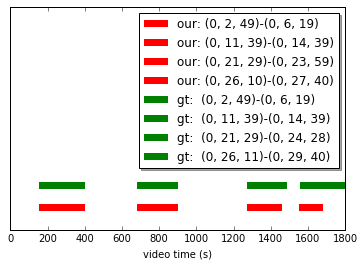

In [91]:
# check groundtruth
groundtruth = commercial_gt[video_name]['span']
correct = True
if len(commercial_list) != len(groundtruth):
    print("Error: number of commercial are not correct!!!") 
    correct = False
for i in range(len(groundtruth)):
    if np.fabs(get_time_difference(groundtruth[i][0], commercial_list[i][0][1])) >= 2 \
        or np.fabs(get_time_difference(groundtruth[i][1], commercial_list[i][1][1])) >= 2:
        correct = False
        break
if correct:
    print("All commercials are correct!!!")
else:
    print("Error: commercials are not correct!!!")

visualize_commercial(commercial_list, groundtruth)    